In [1]:
import pandas as pd
df = pd.read_csv('Data/greenroute_travel_data.csv', on_bad_lines='skip', encoding='latin1')
df.head()

,trip_id,origin,destination,distance_km,vehicle_type,avg_speed_kmph,traffic_level,weather,temperature_c,co2_emission_g_km
0,1,City Center,Park,19.06,Diesel Car,33.4,Medium,Rainy,35.1,264.0
1,2,City Center,University,11.70,Petrol Car,25.6,Low,Rainy,20.3,217.8
2,3,Airport,Train Station,7.07,Bus,36.7,High,Rainy,2.2,357.5
3,4,Industrial Zone,Downtown,8.39,Diesel Car,77.4,Medium,Clear,-0.6,220.0
4,5,Suburb B,University,8.08,Petrol Car,63.8,Medium,Snowy,12.0,234.0


In [2]:
df.rename(columns={
    'distance_km': 'distance',
    'vehicle_type': 'vehicle',
    'avg_speed_kmph': 'speed',
    'traffic_level': 'traffic',
    'temperature_c':'temp',
    'co2_emission_g_km': 'co2_emission'}
    , inplace=True)

In [3]:
df.head(1)

,trip_id,origin,destination,distance,vehicle,speed,traffic,weather,temp,co2_emission
0,1,City Center,Park,19.06,Diesel Car,33.4,Medium,Rainy,35.1,264.0


In [4]:
df.shape

(1000, 10)

In [6]:
df.columns

Index(['trip_id', 'origin', 'destination', 'distance', 'vehicle', 'speed',
       'traffic', 'weather', 'temp', 'co2_emission'],
      dtype='object')

In [7]:
X = df[['distance', 'vehicle', 'speed','traffic', 'weather', 'temp']]
y = df['co2_emission']

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape)
print(X_test.shape)

(800, 6)
(200, 6)


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['vehicle', 'traffic', 'weather']
numerical_features = ['distance', 'speed', 'temp']

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

In [12]:
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

In [13]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vehicle', 'traffic',
                                                   'weather']),
                                                 ('num', 'passthrough',
                                                  ['distance', 'speed',
                                                   'temp'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [14]:
y_pred = model_pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [15]:
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

Mean Absolute Error: 0.9777050000000052
R2 Score: 0.9989918355336365
Mean Squared Error: 10.462002544999995
Root Mean Squared Error: 3.234501900602316


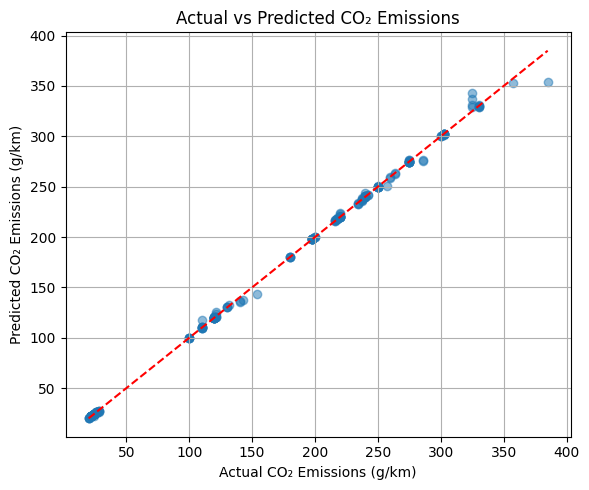

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual CO₂ Emissions (g/km)")
plt.ylabel("Predicted CO₂ Emissions (g/km)")
plt.title("Actual vs Predicted CO₂ Emissions")
plt.grid(True)
plt.tight_layout()

In [17]:
df.head()

,trip_id,origin,destination,distance,vehicle,speed,traffic,weather,temp,co2_emission
0,1,City Center,Park,19.06,Diesel Car,33.4,Medium,Rainy,35.1,264.0
1,2,City Center,University,11.70,Petrol Car,25.6,Low,Rainy,20.3,217.8
2,3,Airport,Train Station,7.07,Bus,36.7,High,Rainy,2.2,357.5
3,4,Industrial Zone,Downtown,8.39,Diesel Car,77.4,Medium,Clear,-0.6,220.0
4,5,Suburb B,University,8.08,Petrol Car,63.8,Medium,Snowy,12.0,234.0


In [18]:
sample_input = pd.DataFrame([{
    "distance": 8.08,
    "vehicle": "Petrol Car",
    "speed": 63.8,
    "traffic": "Medium",
    "weather": "Snowy",
    "temp": 12.0
}])

sample_prediction = model_pipeline.predict(sample_input)[0]
sample_prediction

232.92

In [19]:
C02AllEmissions = sample_input['distance']*sample_prediction
print(f"Predicted CO₂ Emissions for the sample input: {sample_prediction} g/km")
print(f"Total CO₂ Emissions for the sample input: {C02AllEmissions.values[0]} kg")

Predicted CO₂ Emissions for the sample input: 232.92 g/km
Total CO₂ Emissions for the sample input: 1881.9936 kg


In [20]:
origins = df['origin'].unique()
destinations = df['destination'].unique()

origin_dest_distance = {
    (row['origin'], row['destination']): row['distance']
    for _, row in df.iterrows()
}

In [22]:
import pickle
with open('model/model_pipeline.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

with open("model/origins.pkl", "wb") as f:
    pickle.dump(origins, f)

with open("model/destinations.pkl", "wb") as f:
    pickle.dump(destinations, f)

with open("model/origin_dest_distance.pkl", "wb") as f:
    pickle.dump(origin_dest_distance, f)